In [1]:
#using soup environment, python version 3.7.0
import numpy as np
import matplotlib.pyplot as plt

from utils.myutils import *
from pathlib import Path
from resize.scipy import resize
import nibabel as nib
from tqdm import tqdm
import pandas as pd


import image_similarity_measures
from image_similarity_measures.quality_metrics import ssim, psnr,issm,fsim
from vif.vif_utils import vif
import cpbd
import statistics

In [2]:
ssim_df = pd.read_csv('sm_ssim_df.csv')
psnr_df = pd.read_csv('sm_psnr_df.csv')
vif_df = pd.read_csv('sm_vif_df.csv')
cpbd_df = pd.read_csv('sm_cpbd_df.csv')

In [3]:
#load HR, soup and synthSR
hr_path = Path("/iacl/pg22/sam/data/OASIS3/OASIS3_iso/")
hr = list(hr_path.iterdir())
hr_list = hr[0:10]

In [4]:
#smore list
sm_path = Path("/iacl/pg22/ashley/order_output/")
sm_list = list(sm_path.iterdir()) #order is not right

#rearrange sm_list manually
order = [2,1,7,5,4,8,3,6,0,9]

sm_ordered_list = []
for num in order:
    sm_ordered_list.append(sm_list[num])

In [5]:
#create hr_image list
hr_images = []
for hr in hr_list:
    im = nib.load(hr)
    hr_img = im.get_fdata(dtype=np.float32)
    hr_images.append(hr_img)

In [6]:
sm_images = []
for sm in sm_ordered_list:
    im = nib.load(sm)
    sm_img = im.get_fdata(dtype=np.float32)
    sm_images.append(sm_img)

In [7]:
import skimage

In [8]:
#calculate vif for 3D volumes, returns the average of slices
def vif3d(vol1,vol2):
    score = 0
    for i in range(vol1.shape[0]):
        score += vif(vol1[i,:,:],vol2[i,:,:])
    
    final = score / vol1.shape[0]
    return final

In [9]:
#calculate vif for 3D volumes, returns the average of the slices
def cpbd3d(vol):
    score = 0
    for i in range(vol.shape[0]):
        score += cpbd.compute(vol[i,:,:])
    final = score / vol.shape[0]
    return final

In [18]:
sm_blur = []
for sm in sm_images: 
    blurred = np.empty(shape=(176,256,256))
    for sl in range(0,sm.shape[0]):
        blurred[sl,:,:] = skimage.filters.gaussian(sm[sl,:,:], 1) #sigma= 1, "nearest"

    sm_blur.append(blurred)


In [19]:
sm_noise = []
for sm in sm_images: 
    noised = np.empty(shape=(176,256,256))
    for sl in range(0,sm.shape[0]):
        #var is std**2, default is 0.01
        noised[sl,:,:] = skimage.util.random_noise(sm[sl,:,:], mode='gaussian',seed=None, clip=False,var=10)

    sm_noise.append(noised)

(-0.5, 255.5, 255.5, -0.5)

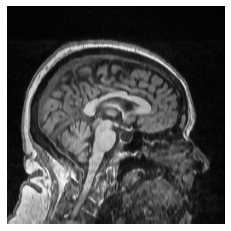

In [24]:
plt.imshow(np.rot90( sm_noise[4][88,:,:]),cmap="Greys_r",vmin=sm_images[4][88,:,:].min(), 
           vmax=sm_images[4][88,:,:].max())
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

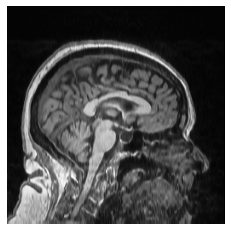

In [22]:
plt.imshow(np.rot90(sm_images[4][88,:,:]),cmap="Greys_r")
plt.axis("off")

In [57]:
smore_vif = []
bvif = []
nvif = []

smore_ssim=[]
bssim= []
nssim=[]

smore_psnr=[]
bpsnr =[]
npsnr=[]

smore_cpbd=[]
bcpbd = []
ncpbd=[]

In [58]:
for i in tqdm(range(0,10)):
    #hr
    hr_img = hr_images[i]
    mp = hr_img.max() - hr_img.min()
    
    #smore
    sm_img = sm_images[i]
    
    b = sm_blur[i]
    n=sm_noise[i]
    
    
    #add to vif dataframe 
    smvif = vif3d(hr_img, sm_img)
    smore_vif.append(smvif)
    
    bv = vif3d(hr_img, b)
    bvif.append(bv)
    
    nv = vif3d(hr_img, n)
    nvif.append(nv)
    
    #add to psnr dataframe
    
    smp = psnr(hr_img, sm_img ,max_p = mp)
    smore_psnr.append(smp)
    
    bv = psnr(hr_img, b,max_p = mp)
    bpsnr.append(bv)
    
    nv = psnr(hr_img, n,max_p = mp)
    npsnr.append(nv)
    
   
    sms = ssim(hr_img, sm_img ,max_p = mp)
    smore_ssim.append(sms)
    
    bv = ssim(hr_img, b,max_p = mp)
    bssim.append(bv)
    
    nv = ssim(hr_img, n, max_p = mp)
    nssim.append(nv)
   
    
    #cpbd
    hrcp = cpbd3d(normalize(hr_img,255))
    
    smcp = cpbd3d(normalize(sm_img,255))
    smore_cpbd.append(smcp / hrcp)
    
    bcp = cpbd3d(normalize(b,255))
    bcpbd.append(bcp / hrcp)
    
    ncp = cpbd3d(normalize(n,255))
    ncpbd.append(ncp / hrcp)
    
    #power/frequency
    #add later

100%|██████████████████████████████████████████| 10/10 [49:38<00:00, 297.84s/it]


In [59]:
vif_df = pd.DataFrame(columns=['SMORE','Blur','Noise'])
psnr_df = pd.DataFrame(columns=['SMORE','Blur','Noise'])
ssim_df = pd.DataFrame(columns=['SMORE','Blur','Noise'])
cpbd_df = pd.DataFrame(columns=['SMORE','Blur','Noise'])

In [75]:
sm_images[4].max()

1038.2642

(-0.5, 255.5, 255.5, -0.5)

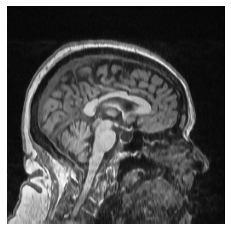

In [71]:
plt.imshow(np.rot90(sm_noise[4][88,:,:]),cmap="Greys_r")
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

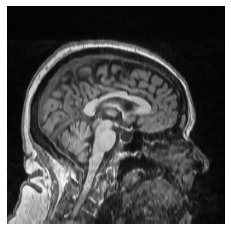

In [73]:
plt.imshow(np.rot90(sm_images[4][88,:,:]),cmap="Greys_r")
plt.axis("off")

In [61]:
vif_df['SMORE'] =smore_vif
vif_df['Blur'] = bvif
vif_df['Noise'] =nvif

psnr_df['SMORE'] =smore_psnr
psnr_df['Blur'] = bpsnr
psnr_df['Noise'] =npsnr


ssim_df['SMORE'] =smore_ssim
ssim_df['Blur'] = bssim
ssim_df['Noise'] = nssim


cpbd_df['SMORE'] =smore_cpbd
cpbd_df['Blur'] = bcpbd
cpbd_df['Noise'] = ncpbd

In [62]:
ssim_df.to_csv('sm_ssim_df.csv')
psnr_df.to_csv('sm_psnr_df.csv')
vif_df.to_csv('sm_vif_df.csv')
cpbd_df.to_csv('sm_cpbd_df.csv')

In [63]:
import seaborn as sns
sns.set_theme(style="whitegrid")

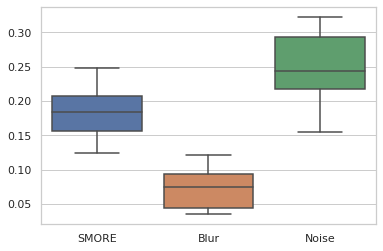

In [64]:
ax = sns.boxplot(data=cpbd_df)

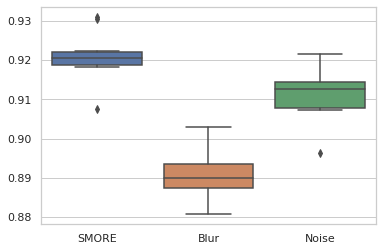

In [65]:
ax2 = sns.boxplot(data=ssim_df)

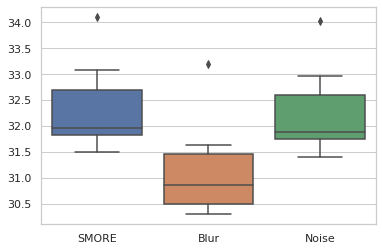

In [66]:
ax3 = sns.boxplot(data=psnr_df)

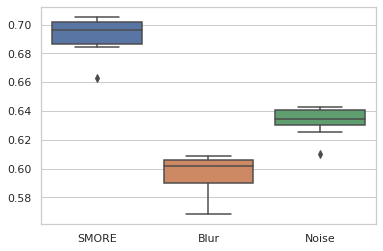

In [67]:
ax4 = sns.boxplot(data=vif_df)

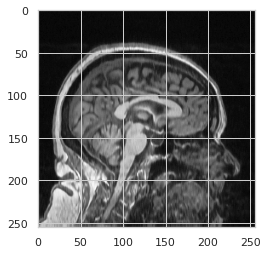

In [68]:
plt.imshow(np.rot90(sm_noise[4][88,:,:]),cmap="Greys_r")